Camera calibration

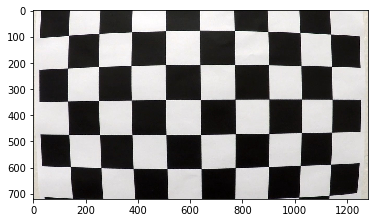

In [1]:
# importing packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# read and display a calibration image
image = mpimg.imread('camera_cal/calibration1.jpg')
plt.imshow(image)

Looks good!
Now lets load all the images and calibrate the camera

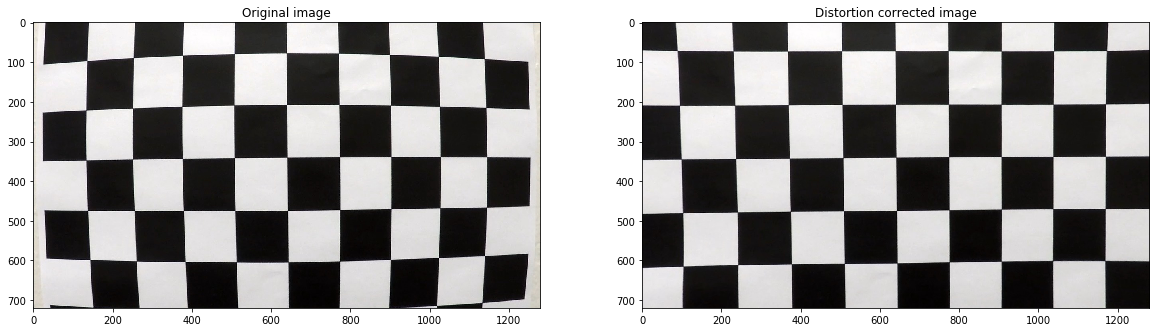

In [22]:
import glob

# Read in all the images into a list
images = glob.glob('camera_cal/calibration*.jpg')

# array to store object points and image points for all the images

objpoints = [] # 3D object points in real world images
imgpoints = [] # 2D points in image plane

# prepare object points like (0,0,0), (1,0,0), etc.
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

for file_name in images:
    # read file
    image = mpimg.imread(file_name)
    # convert to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If corners are found, append object points and image points
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

# find camera calibration matrix and distortion coefficients        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
image = mpimg.imread("camera_cal/calibration1.jpg")
chess_undistort = cv2.undistort(image, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    
ax1.set_title('Original image')
ax1.imshow(image)

ax2.set_title('Distortion corrected image')
ax2.imshow(chess_undistort)

Now lets load a straight lines image and draw a grid on the image so that we can eyeball the points needed for perspective transform.

image shape is  (720, 1280, 3)


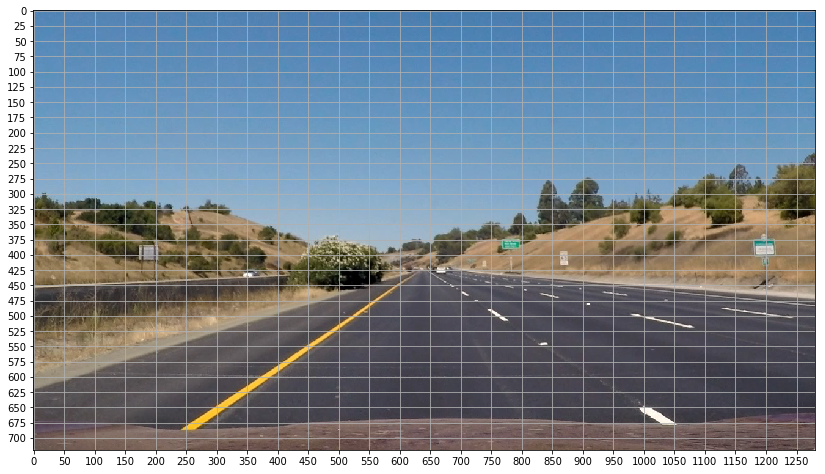

In [14]:
def draw_grid_on_image(image):
    """
    Draw grid on the image to determine appropriate region of interest
    Only used for debug purposes
    """
    imshape = image.shape
    print("image shape is ", imshape)
    fig = plt.figure(figsize = (14, 24))
    ax = fig.gca()
    x_grid = 50
    y_grid = 25
    ax.set_xticks(np.arange(0, imshape[1], x_grid))
    ax.set_yticks(np.arange(0, imshape[0], y_grid))
    plt.grid(True)
    # Display the image
    plt.imshow(image)

image = mpimg.imread("test_images/straight_lines1.jpg")

draw_grid_on_image(image)

Lets define some utility functions for drawing lines on images, undistorting camera images, thresholding and warping.

In [4]:
# source points
sx1, sy1, sx2, sy2, sx3, sy3, sx4, sy4 = 170, 720, 595, 450, 730, 450, 1150, 720
src = np.float32([[sx1, sy1],[sx2, sy2],[sx3, sy3],[sx4, sy4]]) 

# destination points
dx1, dy1, dx2, dy2, dx3, dy3, dx4, dy4 = 320, 720, 320, 0, 960, 0, 960, 720 
dst = np.float32([[dx1, dy1],[dx2, dy2],[dx3, dy3],[dx4, dy4]]) 


def filter_color(image, lower, upper):
    """
    Applies a mask to isolate colors in HSV color space using lowe and upper tuples
    :param image: RGB image
    :param lower: tuple of lower mask
    :param upper: tuple of upper mask
    :return: image filtered with the mask
    :return: mask
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    image = cv2.bitwise_and(image, image, mask = mask)
    return image, mask


def draw_line_image(image, lines, color=[255, 0, 0], thickness=10):
    """
    returns an image with lines on them specified by lines
    :param image: RGB image
    :param lines: lines to be drawn
    :param color: line of color
    :thickness: thickness of line
    :returns: image with line drawn
    """
    line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    for line in lines:
        cv2.line(line_image, (line[0], line[1]), (line[2], line[3]), color, thickness)
    return line_image

def weighted_image(image, initial_image, α=0.8, β=1., γ=0.):
    """
    The result image is computed as follows -> initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    :param image: image with lines drawn on them
    :param initial_img: original image without any processing
    :returns: weighted image initial_img * α + img * β + γ
    """
    return cv2.addWeighted(initial_image, α, image, β, γ)


def undistort_image(image):
    """
    undistort image
    :param image: original distorted image
    :returns undistorted image
    """
    return cv2.undistort(image, mtx, dist, None, mtx)

# Color & gradient thresholding
def thresholding(image, r_thresh=(200, 255), s_thresh=(170, 255), sx_thresh=(20, 100)):
    """
    returns (R&S)|sobel-x where R is the R thresholded image (from RGB), 
                  S is the S thresholded image (from HLS), and 
                  sx_thresh is the sobel-x thresholded image
    :param image: RGB image
    :param r_thresh: R channel threshold
    :param s_thresh: S channel threshold
    :param sx_thresh: gradient x threshold
    """
    # Convert to HLS color space and separate the V channel
    r_channel = image[:,:,0]
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = 5) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold R channel
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold S channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack((r_binary, sxbinary, s_binary)) * 255
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((r_binary == 1) & (s_binary == 1)) | (sxbinary == 1)] = 1
    return r_binary, s_binary, sxbinary, color_binary, combined_binary

def warp(image, src, dst):
    """
    returns perspective transform of an image and a matrix used to invert the transform
    """
    image_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_image = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    return warped_image, Minv


def mask_and_plot(image):
    """
    masks and plots an image - applies both yellow and white masks
    """
    yellow_image, mask_yellow = filter_color(image, np.array([20,100,100]), np.array([50,255,255]))
    white_image, mask_white = filter_color(image, np.array([0,0,220]), np.array([255,35,255]))
    mask_comb = cv2.bitwise_or(mask_yellow, mask_white)
    # Plotting thresholded images
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,10))
    ax1.set_title('Yellow masked image')
    ax1.imshow(yellow_image)

    ax2.set_title('Yellow mask')
    ax2.imshow(mask_yellow, cmap='gray')
    
    ax3.set_title('White masked image')
    ax3.imshow(white_image)

    ax4.set_title('White mask')
    ax4.imshow(mask_white, cmap='gray')
    
    ax5.set_title('Combined mask')
    ax5.imshow(mask_comb, cmap='gray')
    
    

def threshold_and_plot(image):
    """
    applies (R&S|S_x) thresholding and plots the image
    where R is red channel, S is saturation of HLS colorspace,
    and S_x is sobel x operator
    """
    r_binary, s_binary, sxbinary, color_binary, combined_binary = thresholding(image)
    # Plotting thresholded images
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20,10))
    
    ax1.set_title('R threshold')
    ax1.imshow(r_binary, cmap='gray')
    
    ax2.set_title('S threshold')
    ax2.imshow(s_binary, cmap='gray')
    
    ax3.set_title('Sobel-x threshold')
    ax3.imshow(sxbinary, cmap='gray')
    
    ax4.set_title('Stacked thresholds')
    ax4.imshow(color_binary)

    ax5.set_title('Combined R, S and Sobel-x thresholds')
    ax5.imshow(combined_binary, cmap='gray')

def warp_and_plot(image):
    """
    warps (perspective transform) and plots the image
    """
    warped_image, _ = warp(image, src, dst)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

    lines = [[sx1, sy1, sx2, sy2], 
             [sx2, sy2, sx3, sy3], 
             [sx3, sy3, sx4, sy4], 
             [sx4, sy4, sx1, sy1]]

    ax1.set_title('Source image')
    ax1.imshow(weighted_image(draw_line_image(image, lines), image))

    lines = [[dx1, dy1, dx2, dy2], 
             [dx2, dy2, dx3, dy3], 
             [dx3, dy3, dx4, dy4], 
             [dx4, dy4, dx1, dy1]]

    ax2.set_title('Warped image')
    # ax2.imshow(weighted_image(draw_line_image(warped_image, lines), warped_image))
    ax2.imshow(warped_image)

Lets try these functions out

Text(0.5,1,'Original image')

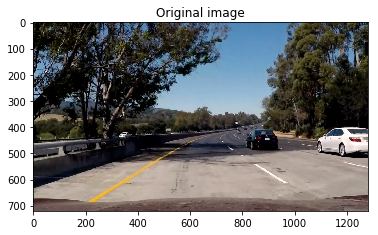

In [5]:
# image = mpimg.imread("video_images/2018_07_18_03_12_48_324.jpg")
# image = mpimg.imread("video_images/2018_07_18_03_12_34_518.jpg")
image = mpimg.imread("test_images/test5.jpg")
# image = mpimg.imread("video_images/2018_07_19_03_28_37_268.jpg")
# image = mpimg.imread("video_images/2018_07_19_05_32_19_972.jpg")
# image = mpimg.imread("video_images/2018_07_20_07_02_06_327.jpg")
# image = mpimg.imread("video_images/2018_07_18_03_12_57_494.jpg")
# image = mpimg.imread("video_images/2018_07_18_03_12_34_518.jpg")
# image = mpimg.imread("debug_images/2018_07_25_07_16_22_330.jpg")
plt.imshow(image)
plt.title("Original image")

Text(0.5,1,'Undistorted image')

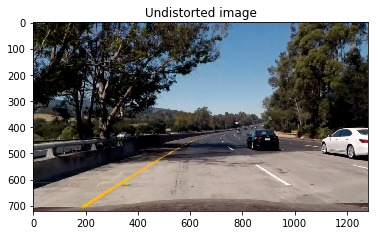

In [6]:
undistorted_image = undistort_image(image)
plt.imshow(undistorted_image)
plt.title("Undistorted image")

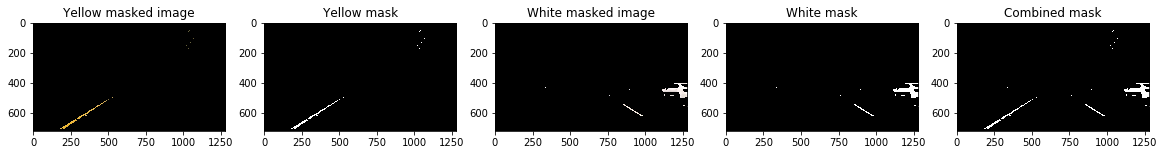

In [7]:
mask_and_plot(undistorted_image)

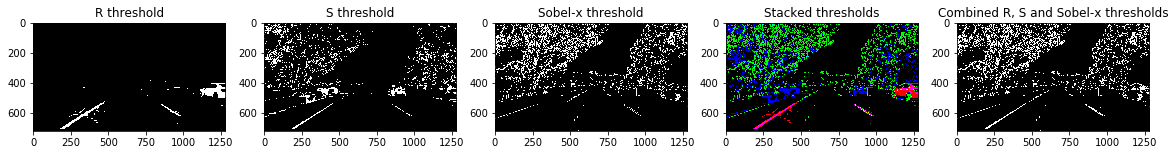

In [8]:
threshold_and_plot(undistorted_image)

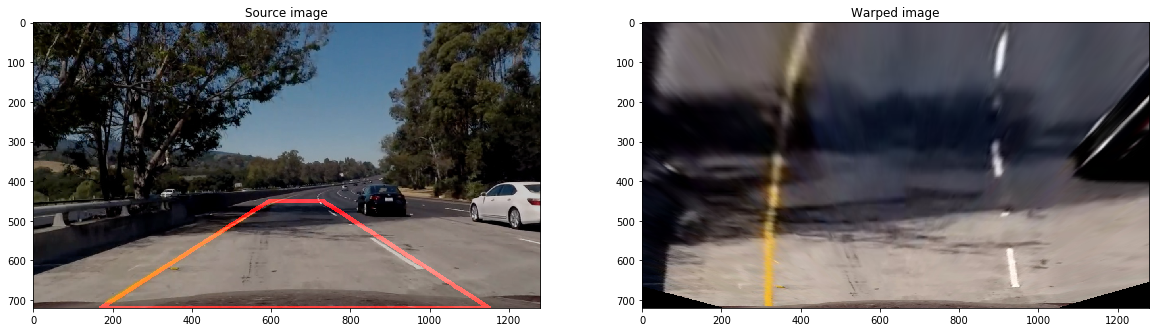

In [9]:
warp_and_plot(undistorted_image)

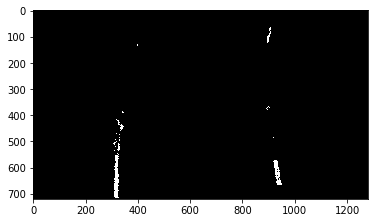

In [11]:
_, _, _, _, threshold_image = thresholding(undistorted_image)
_, mask_yellow = filter_color(undistorted_image, np.array([20,100,100]), np.array([50,255,255]))
_, mask_white = filter_color(undistorted_image, np.array([0,0,220]), np.array([255,35,255]))
mask = cv2.bitwise_or(mask_white, mask_yellow)
comb_image = np.zeros_like(threshold_image)
comb_image[(mask > 0)&(threshold_image == 1)] = 1
warped_image, _ = warp(comb_image, src, dst)
plt.imshow(warped_image, cmap = 'gray')

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Define a class to receive the characteristics of each line detection
n = 3
# reset search after 10 frames
reset_search = 20

# Line class to keep track of last n fits
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None # return best fit based on last n fits
        self.last_n_fits = [] # list of last n fits
        self.frames_not_detected = 0 # keep track of number of undetected images
        self.radius_of_curvature = 0
    
    def calculate_fit(self, fit):
        """
        function that returns average of last 'n' polynomial fits
        :param fit: polynomial fit for current frame
        :returns: average of last 'n' fits
        """
        if self.detected:
            self.last_n_fits.append(fit)
            if len(self.last_n_fits) > n:
                self.last_n_fits.pop(0)
        else:
            self.frames_not_detected += 1     
        self.best_fit = np.average(self.last_n_fits, axis = 0)  
        return self.best_fit   

Text(0.5,1,'Lane lines superimposed on original image')

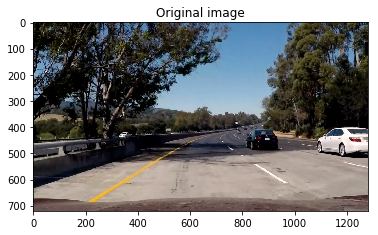

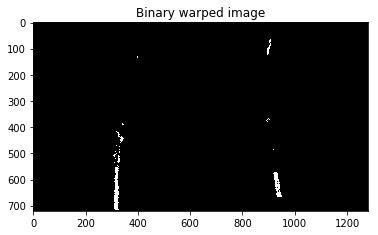

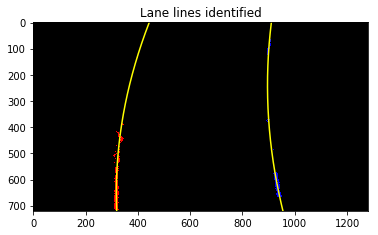

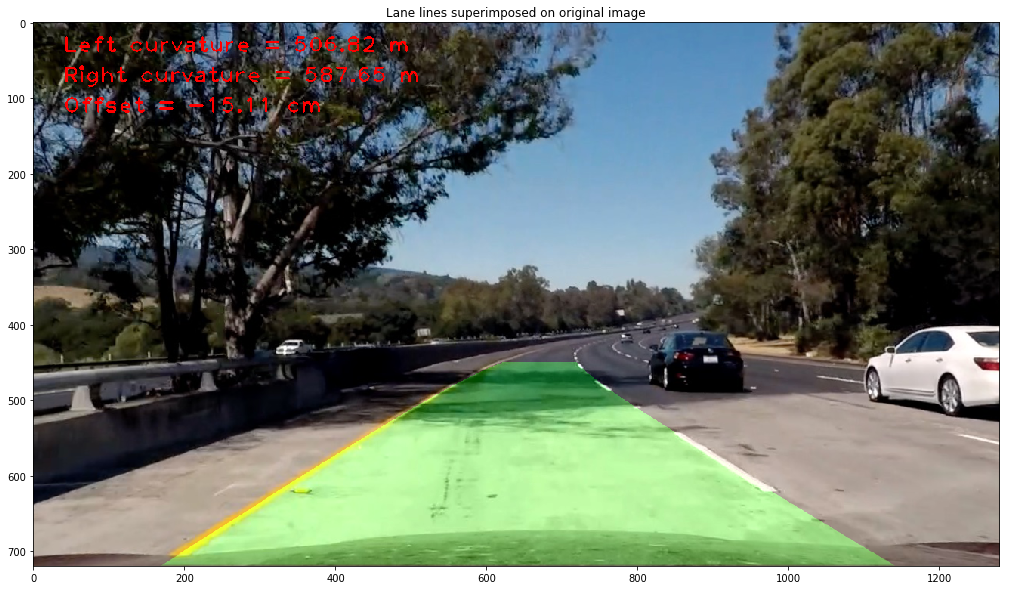

In [20]:
# for radius of curvature
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/(dx4 - dx1) # meters per pixel in x dimension

def sanity_check(lx, rx):
    """
    function returns True or False depending on if the lane width around the
    bottom of the image is within +/- margin of lane width
    """
    margin = 100
    lane_width = rx-lx
    if rx[-1]-lx[-1] < (dx4-dx1) - margin or rx[-1]-lx[-1] > (dx4-dx1) + margin:
        return False
    return True

def find_lane_pixels(binary_warped):
    """
    this function finds the lane pixels
    """
    offset = 200
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = offset + np.argmax(histogram[offset:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        # cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        # (win_xleft_high,win_y_high),(0,255,0), 2) 
        # cv2.rectangle(out_img,(win_xright_low,win_y_low),
        # (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def polyfit_using_prev(binary_warped, left_fit, right_fit):
    """
    this function finds the lane pixels in the current frame using lane line pixels
    from the previous frame
    """
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty

def eval_at_y(poly, y):
    """
    function evaluates a polynomial at y
    """
    return poly[0]*y**2 + poly[1]*y + poly[2]
    

def fit_polynomial(binary_warped, plot = False):
    """
    function fits a polynomial on a binary image
    """
    image_shape = binary_warped.shape
    left_curverad = left_line.radius_of_curvature
    right_curverad = right_line.radius_of_curvature
    # Find our lane pixels first
    if (not left_line.detected and left_line.frames_not_detected > \
                                                reset_search) or len(left_line.last_n_fits) == 0:
        leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)
    else:
        leftx, lefty, rightx, righty = \
        polyfit_using_prev(binary_warped, left_line.last_n_fits[-1], right_line.last_n_fits[-1])
        # leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, image_shape[0]-1, image_shape[0])
    if len(lefty) !=0 and len(righty) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        left_curverad, right_curverad = measure_curvature_real(left_fit, right_fit, image_shape[0]-1)
        left_line.radius_of_curvature = left_curverad
        right_line.radius_of_curvature = right_curverad
    
        left_fitx = eval_at_y(left_fit, ploty)
        right_fitx = eval_at_y(right_fit, ploty)
        if not sanity_check(left_fitx, right_fitx):
            left_line.detected = False
            right_line.detected = False
        else:
            left_line.detected = True
            right_line.detected = True
    else:
        left_fit =[]
        right_fit = []
        left_line.detected = False
        right_line.detected = False
    
        
    if not plot:
        left_fit = left_line.calculate_fit(left_fit)
        right_fit = right_line.calculate_fit(right_fit)
    
    
    offset = 0
    # calculate offset from center of lane
    if len(left_fit) != 0:
        left_fitx = eval_at_y(left_fit, ploty)
        right_fitx = eval_at_y(right_fit, ploty)

        left_bottom_x = left_fitx[-1]
        right_bottom_x = right_fitx[-1]
        # offset calculation
        lane_midpoint = (left_bottom_x + right_bottom_x)/2.0
        camera_midpoint = (image_shape[1]-1)/2.0
        offset = (lane_midpoint - camera_midpoint)*xm_per_pix
    
    if plot:
        ## Visualization ##
        # Colors in the left and right lane regions
        # Create an output image to draw on and visualize the result
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        plt.figure(3)
        if not left_line.detected:
            print('Sanity check failed, displaying rejected lines')
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        # plt.xlim(0, image_shape[1])
        # plt.ylim(image_shape[0], 0)
        plt.imshow(out_img)
        plt.title("Lane lines identified")
    return left_fitx, right_fitx, ploty, left_curverad, right_curverad, offset 

def measure_curvature_real(left_fit, right_fit, y_eval):
    """
    measures the curvature in meters
    """
    # Define conversions in x and y from pixels space to meters
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.zeros_like(left_fit)
    left_fit_cr[0] = left_fit[0]*xm_per_pix/ym_per_pix**2
    left_fit_cr[1] = left_fit[1]*xm_per_pix/ym_per_pix
    left_fit_cr[2] = left_fit[2]*xm_per_pix
    
    right_fit_cr = np.zeros_like(right_fit)
    right_fit_cr[0] = right_fit[0]*xm_per_pix/ym_per_pix**2
    right_fit_cr[1] = right_fit[1]*xm_per_pix/ym_per_pix
    right_fit_cr[2] = right_fit[2]*xm_per_pix
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + \
                           left_fit_cr[1])**2)**1.5) / (2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + \
                            right_fit_cr[1])**2)**1.5) / (2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return(left_curverad, right_curverad)

def mark_lane_lines(undist, warped, ploty, left_fitx, right_fitx, Minv):
    """
    function returns an image with lane lines marked on input image
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result
    
def pipeline(image, plot = False):
    """
    pipeline for images, is also used to plot intermediate image outputs
    """
    # undistort image
    undistorted_image = undistort_image(image)
    
    # R&S|sobel-x thresholding
    _, _, _, _, threshold_image = thresholding(undistorted_image)
    
    # yellow mask
    _, mask_yellow = filter_color(undistorted_image, np.array([20,100,100]), np.array([50,255,255]))
    
    # white mask
    _, mask_white = filter_color(undistorted_image, np.array([0,0,220]), np.array([255,35,255]))
    
    # combine yellow and white mask
    mask = cv2.bitwise_or(mask_yellow, mask_white)
    comb_image = np.zeros_like(threshold_image)
    
    # combine mask and thresholded image
    comb_image[(mask > 0)&(threshold_image == 1)] = 1
    
    # warp the binary image
    warped_image, Minv = warp(comb_image, src, dst)
    if plot:
        plt.figure(2)
        plt.imshow(warped_image, cmap = "gray")
        plt.title("Binary warped image")
    
    # calculate polynomial fit
    left_fitx, right_fitx, ploty, left_curverad, right_curverad, offset = fit_polynomial(warped_image, plot)
    
    # superimpose lines on top of the polynomial
    superimposed_image = mark_lane_lines(undistorted_image, warped_image, ploty, left_fitx, right_fitx, Minv)
    cv2.putText(superimposed_image, "Left curvature = " + str(np.round(left_curverad, 2)) + " m",(40,40), \
                                        cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0), 2)
    cv2.putText(superimposed_image,"Right curvature = " + str(np.round(right_curverad, 2)) + " m",(40,80), \
                                        cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0), 2)
    cv2.putText(superimposed_image,"Offset = " + str(np.round(offset*1000, 2)) + " cm",(40,120), \
                                        cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0), 2)
    
    return superimposed_image
    
    
def pipeline_for_video(image):
    """
    pipeline for video, does not plot any intermediate images
    """
    # undistort image
    undistorted_image = undistort_image(image)
    
    # R&S|sobel-x thresholding
    _, _, _, _, threshold_image = thresholding(undistorted_image)
    
    # yellow mask
    _, mask_yellow = filter_color(undistorted_image, np.array([20,100,100]), np.array([50,255,255]))
    
    # white mask
    _, mask_white = filter_color(undistorted_image, np.array([0,0,215]), np.array([255,40,255]))
    
    # combine yellow and white mask
    mask = cv2.bitwise_or(mask_yellow, mask_white)
    comb_image = np.zeros_like(threshold_image)
    
    # combine mask and thresholded image
    comb_image[(mask > 0)&(threshold_image == 1)] = 1
    
    # warp the binary image
    warped_image, Minv = warp(comb_image, src, dst)
    
    # calculate polynomial fit
    left_fitx, right_fitx, ploty, left_curverad, right_curverad, offset = fit_polynomial(warped_image)
    
    # superimpose lines on top of the polynomial
    superimposed_image = mark_lane_lines(undistorted_image, warped_image, ploty, left_fitx, right_fitx, Minv)
    cv2.putText(superimposed_image, "Left curvature = " + str(np.round(left_curverad, 2)) + " m",(40,40), \
                                        cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 2)
    cv2.putText(superimposed_image,"Right curvature = " + str(np.round(right_curverad, 2)) + " m",(40,80), \
                                        cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 2)
    cv2.putText(superimposed_image,"Offset = " + str(np.round(offset*1000, 2)) + " cm",(40,120), \
                                        cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 2)
    return superimposed_image

right_line = Line()
left_line = Line()
image = mpimg.imread("test_images/test5.jpg")
# image = mpimg.imread("video_images/2018_07_19_03_28_37_268.jpg")
# image = mpimg.imread("video_images/2018_07_18_03_12_48_324.jpg")
# image = mpimg.imread("video_images/2018_07_19_05_32_19_972.jpg")
# image = mpimg.imread("video_images/2018_07_18_03_12_56_239.jpg")
# image = mpimg.imread("video_images/2018_07_18_03_12_49_805.jpg")
# image = mpimg.imread("video_images/2018_07_19_05_32_16_995.jpg")
# image = mpimg.imread("video_images/2018_07_18_03_12_34_518.jpg")
# image = mpimg.imread("video_images/2018_07_18_03_12_31_818.jpg")
# image = mpimg.imread("debug_images/2018_07_25_07_16_22_330.jpg")
plt.figure(1)
plt.imshow(image)
plt.title("Original image")
output_image = pipeline(image, plot = True)
plt.figure(figsize=(20,10))
plt.imshow(output_image)
plt.title("Lane lines superimposed on original image")

In [21]:
output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_for_video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:00<00:00,  5.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 52s, sys: 31.6 s, total: 5min 23s
Wall time: 4min 2s


In [ ]:
output = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
white_clip = clip2.fl_image(pipeline_for_video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)